# Example 1: Hupsel Brook model

This is the cases study #1 from the chapter 12 of the SWAP manual. This notebook aims to present the way the model is created in pySWAP package. It goes through the process of setting up the model, running the model and plotting the Epot results.

In [1]:
from datetime import date as dt
from pandas import DataFrame
from pyswap.core.metadata import Metadata
from pyswap.core.simsettings import SimSettings
from pyswap.atmosphere import Meteorology, load_from_knmi, PenmanMonteith
from pyswap.plant.createcrop import (Preparation, OxygenStress, DroughtStress,
                                     Interception, CropDevelopmentSettingsFixed, CropDevelopmentSettingsWOFOST)
from pyswap.plant import CropFile, Crop
from pyswap.irrigation import Irrigation, FixedIrrigation
from pyswap.soilwater import (
    SoilMoisture, SurfaceFlow, Evaporation, SoilProfile)
from pyswap.drainage import LateralDrainage
from pyswap.core.boundary import BottomBoundary
from pyswap.core.model import Model
from pyswap.drainage.createdra.drafile import DraSettings, DrainageFormula, DraFile


## 1. Setting up the model

For each major section of the main swp file, there is a class in pySWAP that needs to be created. Then, all the objects are collected into the main Model class that is responsible for running the model and capturing the results. Some auxiliary files like .crp have their own class objects that need to be created and attached to the main class for the section.

### Metadata and Simulation Settings

In [2]:
meta = Metadata(author="John Doe",
                institution="University of Somewhere",
                email="john.doe@somewhere.com",
                project="pySWAP test - hupsel brook",
                swap_ver="4.2")

simset = SimSettings(
    tstart='2002-01-01',
    tend='2004-12-31',
    nprintday=1,
    swmonth=1,
    swyrvar=0,
    datefix='2004-12-31',
    swvap=1,
    swblc=1,
    swsba=1,
    swinc=1,
    swcsv=1,
    inlist_csv=['pond', 'watbal']
)

### Meteorological settings

For the meteorological section, there are three class objects: 
- PenmanMoteith - in case you want to use P-M method for Evap, the settings are stored there
- MeteorologicalData - this holds the precipitation data
- Meteorology - the main class object for the meteorological settings

In [3]:
pen_mon = PenmanMonteith(
    alt=10.0,
    altw=10.0,
    angstroma=0.25,
    angstromb=0.5,
)

# Obtain the meteorological data from KNMI
meteo_data = load_from_knmi(stations='283')

meteo = Meteorology(
    metfil='283.met',
    lat=52.0,
    swetr=0,
    meteodata=meteo_data,
    penman_monteith=pen_mon,
    swdivide=1,
    swmetdetail=0
)


### Crop settings

Here I have taken the easy way: just opening ready .crp files and saving them further down the lines to the directory where SWAP is executer. However, the .crp files should also be prepared separately, very much the same way the .swp file is prepared. This is presented in a separate notebook.

#### Creating the maize crp file
The CropFile has an option to either open a predefined file from a path, or create a file the same way as a swp file. Below is an example of creating a file for maize.

In [4]:
prep = Preparation(
    swprep=0,
    swsow=0,
    swgerm=0,
    dvsend=3.0,
    swharv=0
)
df_dvs_lai = DataFrame({
    'dvs': [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0],
    'lai': [0.05, 0.14, 0.61, 4.10, 5.00, 5.80, 5.20]
})

df_dvs_ch = DataFrame({
    'dvs': [0.0, 0.3, 0.5, 0.7, 1.0, 1.4, 2.0],
    'ch': [1.0, 15.0, 40.0, 140.0, 170.0, 180.0, 175.0]
})

df_dvs_rd = DataFrame({
    'dvs': [0.0, 0.3, 0.5, 0.7, 1.0, 2.0],
    'rd': [5.0, 20.0, 50.0, 80.0, 90.0, 100.0]
})

df_rrd_rdens = DataFrame({
    'rrd': [0.0, 1.0],
    'rdens': [1.0, 0.0]
})

cropdev_settings = CropDevelopmentSettingsFixed(
    idev=1,
    lcc=168,
    kdif=0.6,
    kdir=0.75,
    swgc=1,
    gctb=df_dvs_lai,
    swcf=2,
    table_dvs_ch=df_dvs_ch,
    albedo=0.23,
    rsc=61.0,
    rsw=0.0,
    swrd=1,
    rdtb=df_dvs_rd,
    rdctb=df_rrd_rdens
)

ox_stress = OxygenStress(
    swoxygen=1,
    swwrtnonox=0,
    aeratecrit=0.5,
    hlim1=-15.0,
    hlim2u=-30.0,
    hlim2l=-30.0,
)

dr_stress = DroughtStress(
    swdrought=1,
    hlim3h=-325.0,
    hlim3l=-600.0,
    hlim4=-8000.0,
    adcrh=0.5,
    adcrl=0.1,
)

# serves both, Fixed crop and WOFOST
interception = Interception(
    swinter=1,
    cofab=0.25
)

crpmaize = CropFile(
    name='maizes',
    prep=prep,
    cropdev_settings=cropdev_settings,
    oxygenstress=ox_stress,
    droughtstress=dr_stress,
    interception=interception
)


#### Creating potato crp file (manual WOFOST setup)

For the WOFOST example, most of the SWAP .crp file will be the same. The crop develompment setup will be different, though.

The Preparation class remains the same as above. In the Hupsel example in the case of potatoes we include gemrmination settings and we make it dependent on temperature and hydrological conditions.

For the crop development settings there are differences:

Part 1: crop factor or crop height -> This one is the same for both and is included in the parent class of both crop settings.

In [5]:
from pyswap.plant.createcrop.cropdev import CropDevelopmentSettingsWOFOST

potato_prep = Preparation(
    swprep=0,
    swsow=0,
    swgerm=2,
    tsumemeopt=170.0,
    tbasem=3.0,
    teffmx=18.0,
    hdrygerm=-500.0,
    hwetgerm=-100.0,
    zgerm=-10.0,
    agerm=203.0,
    dvsend=2.0,
    swharv=0
)

df_dvs_ch = DataFrame({
    'dvs': [0.0, 1.0, 2.0],
    'ch': [1.0, 40.0, 50.0,]
})

dtsmtb = DataFrame({
    'tav': [0.0, 2.0, 13.0, 30.0],
    'dtsm': [0.0, 0.0, 11.0, 28.0]
})

slatb = DataFrame({
    'dvs': [0.0, 1.1, 2.0],
    '7sla': [0.0030, 0.0030, 0.0015]
})

amaxtb = DataFrame({
    'dvs': [0.0, 1.57, 2.0],
    'amax': [30.0, 30.0, 0.0]
})

tmpftb = DataFrame({
    'tavd': [0.0, 3.0, 10.0, 15.0, 20.0, 26.0, 33.0],
    'tmpf': [0.01, 0.01, 0.75, 1.00, 1.00, 0.75, 0.01]
})

tmnftb = DataFrame({
    'tmnr': [0.0, 3.0],
    'tmnf': [0.0, 1.0]
})

rfsetb = DataFrame({
    'dvs': [0.0, 2.0],
    'rfse': [1.0, 1.0]
})

frtb = DataFrame({
    'dvs': [0.00, 1.00, 1.36, 2.00],
    'fr': [0.2, 0.2, 0.0, 0.0]
})

fltb = DataFrame({
    'dvs': [0.00, 1.00, 1.27, 1.36, 2.00],
    'fl': [0.8, 0.8, 0.0, 0.0, 0.0]
})

fstb = DataFrame({
    'dvs': [0.00, 1.00, 1.27, 1.36, 2.00],
    'fs': [0.20, 0.20, 0.25, 0.00, 0.00]
})

fotb = DataFrame({
    'dvs': [0.00, 1.00, 1.27, 1.36, 2.00],
    'fo': [0.00, 0.00, 0.75, 1.00, 1.00]
})

rdrrtb = DataFrame({
    'dvs': [0.0000, 1.5000, 1.5001, 2.0000],
    'rdrr': [0.00, 0.00, 0.02, 0.02]
})

rdrstb = DataFrame({
    'dvs': [0.0000, 1.5000, 1.5001, 2.0000],
    'rdrs': [0.00, 0.00, 0.02, 0.02]
})

rdctb = DataFrame({
    'rrd': [0.0, 1.0],
    'rdens': [1.0, 0.0]
})

potato_cropdev_settings = CropDevelopmentSettingsWOFOST(
    swcf=2,
    table_dvs_ch=df_dvs_ch,
    albedo=0.19,
    rsc=207.0,
    rsw=0.0,
    idsl=0,
    tsumea=150.0,
    tsumam=1550.0,
    dtsmtb=dtsmtb,
    tdwi=75.0,
    laiem=0.0589,
    rgrlai=0.012,
    spa=0.0,
    ssa=0.0,
    span=37.0,
    tbase=2.0,
    slatb=slatb,
    kdif=1.0,
    kdir=0.75,
    eff=0.45,
    amaxtb=amaxtb,
    tmpftb=tmpftb,
    tmnftb=tmnftb,
    cvl=0.72,
    cvo=0.85,
    cvr=0.72,
    cvs=0.69,
    q10=2.0,
    rml=0.03,
    rmo=0.0045,
    rmr=0.01,
    rms=0.015,
    rfsetb=rfsetb,
    frtb=frtb,
    fltb=fltb,
    fstb=fstb,
    fotb=fotb,
    perdl=0.03,
    swrd=2,
    rdi=10.0,
    rri=1.2,
    rdc=50.0,
    swdmi2rd=1,
    rdctb=rdctb,
    rdrstb=rdrstb,
    rdrrtb=rdrrtb
)

potato_ox_stress = OxygenStress(
    swoxygen=1,
    swwrtnonox=1,
    aeratecrit=0.5,
    hlim1=-10.0,
    hlim2u=-25.0,
    hlim2l=-25.0,
    swrootradius=2,
    root_radiuso2=0.00015
)

potato_dr_stress = DroughtStress(
    swdrought=1,
    hlim3h=-300.0,
    hlim3l=-500.0,
    hlim4=-10000.0,
    adcrh=0.5,
    adcrl=0.1,
)

crppotato = CropFile(
    name='potatod',
    prep=potato_prep,
    cropdev_settings=potato_cropdev_settings,
    oxygenstress=potato_ox_stress,
    droughtstress=potato_dr_stress,
    # shared with the fixed crop settings
    interception=interception
)


##### Creating the crop file for maize from the WOFOST database


#### creating the Crop object

In [6]:
croprotation = DataFrame({'cropstart': [dt(2002, 5, 1), dt(2003, 5, 10), dt(2004, 1, 1)],
                            'cropend': [dt(2002, 10, 15), dt(2003, 9, 29), dt(2004, 12, 31)],
                            'cropfil': ["'maizes'", "'potatod'", "'grassd'"],
                            'croptype': [1, 2, 3]})
from pathlib import Path

crp_grass = Path('./data/grassd.crp').absolute()

crop_grassd = CropFile(name='grassd', path=str(crp_grass))

crop = Crop(
    swcrop=1,
    rds=200.0,
    table_croprotation=croprotation,
    cropfiles=[crpmaize, crppotato, crop_grassd]
)

### Irrigation

In [7]:
irrig_events = DataFrame({
    'irdate': ['2002-01-05'],
    'irdepth': [5.0],
    'irconc': [1000.0],
    'irtype': [1]}
)

fixed_irrigation = FixedIrrigation(
    swirgfil=0,
    table_irrigevents=irrig_events
)

irrigation = Irrigation(
    swirfix=1,
    fixedirrig=fixed_irrigation,
    schedule=0
)

### Soil moisture

In [8]:
# implement deep-coping upon changing of the attribute.
soilmoisture = SoilMoisture(
    swinco=2,
    gwli=-75.0
)

In [9]:
list_gwlis = [-75.0, -75.5, -76.0]
list_soil_moisture = [SoilMoisture(
    swinco=2,
    gwli=x
) for x in list_gwlis]

In [10]:
list_soil_moisture

[SoilMoisture(swinco=2, table_head_soildepth=None, gwli=-75.0, inifil=None),
 SoilMoisture(swinco=2, table_head_soildepth=None, gwli=-75.5, inifil=None),
 SoilMoisture(swinco=2, table_head_soildepth=None, gwli=-76.0, inifil=None)]

### Surface flow

In [11]:
surfaceflow = SurfaceFlow(
    swpondmx=0,
    pondmx=0.2,
    rsro=0.5,
    rsroexp=1.0,
    swrunon=0
)

### Evaporation

In [12]:
evaporation = Evaporation(
    cfevappond=1.25,
    swcfbs=0,
    rsoil=30.0,
    swredu=1,
    cofredbl=0.35,
    rsigni=0.5
)

### Soil profile

In [13]:
soil_profile = DataFrame(
    {'ISUBLAY': [1, 2, 3, 4],
        'ISOILLAY': [1, 1, 2, 2],
        'HSUBLAY': [10.0, 20.0, 30.0, 140.0],
        'HCOMP': [1.0, 5.0, 5.0, 10.0],
        'NCOMP': [10, 4, 6, 14]}
)

soil_hydraulic_functions = DataFrame({
    'ORES': [0.01, 0.02],
    'OSAT': [0.42, 0.38],
    'ALFA': [0.0276, 0.0213],
    'NPAR': [1.491, 1.951],
    'KSATFIT': [12.52, 12.68],
    'LEXP': [-1.060, 0.168],
    'ALFAW': [0.0542, 0.0426],
    'H_ENPR': [0.0, 0.0],
    'KSATEXM': [12.52, 12.68],
    'BDENS': [1315.0, 1315.0]
})

soilprofile = SoilProfile(
    swsophy=0,
    table_soilprofile=soil_profile,
    swhyst=0,
    tau=0.2,
    table_soilhydrfunc=soil_hydraulic_functions,
    swmacro=0
)

### Drainage

In [14]:
dra_settings = DraSettings(
    dramet=2,
    swdivd=1,
    cofani=[1.0, 1.0],
    swdislay=0
)

dra_formula = DrainageFormula(
    lm2=11.0,
    shape=0.8,
    wetper=30.0,
    zbotdr=-80.0,
    entres=20.0,
    ipos=2,
    basegw=-200.0,
    khtop=25.0
)

dra_file = DraFile(
    name='swap',
    general=dra_settings,
    drainageformula=dra_formula
)

lateral_drainage = LateralDrainage(
    swdra=1,
    drfil='swap',
    drainagefile=dra_file
)

### Bottom boundary

In [15]:
bottom_boundary = BottomBoundary(
    swbbcfile=0,
    swbotb=6
)

## 2. Running the model

In [16]:
model = Model(
    metadata=meta,
    simsettings=simset,
    meteorology=meteo,
    crop=crop,
    irrigation=irrigation,
    soilmoisture=soilmoisture,
    surfaceflow=surfaceflow,
    evaporation=evaporation,
    soilprofile=soilprofile,
    lateraldrainage=lateral_drainage,
    bottomboundary=bottom_boundary
)


In [17]:
result = model.run('./')

Copying linux executable into temporary directory...
Preparing files...
swap.swp saved.
swap.dra saved.
3 crop file(s) saved.


283.met saved.

 running swap ....
Swap normal completion!

Warnings:


/tmp/ipykernel_8594/1472307555.py:1: Warning: Warning from module Readswap : simulation with additonal Ksat value (Ksatexm)
  result = model.run('./')
/tmp/ipykernel_8594/1472307555.py:1: Warning: Warning from module readcropfixed : SWJARVIS is deprecated, use SWCOMPENSATE instead
  result = model.run('./')


In [18]:
import re

result = re.search(r'.*(Iteration statistics\s*.*)$', result.log, re.DOTALL)

* Project:       swap
* File content:  Main input variables
* File name:     swap.swp
* Model version: Swap 4.2.0
* Generated at:  2024-04-20 19:50:43
 
 Data file   SWAP.SWP with 110 variables parsed by RDINDX
Warning from module Readswap : simulation with additonal Ksat value (Ksatexm)
 Data file   ./SWAP.DRA with  12 variables parsed by RDINDX
metfil.met: all meteo data read and stored.
*----------------------------------------------------------------------*
 Echo of input file:

*----------------------------------------------------------------------*
* Contents of input file: swap.swp                                     *
*----------------------------------------------------------------------*

PROJECT = 'pySWAP test - hupsel brook'
PATHWORK = './'
PATHATM = './'
PATHCROP = './'
PATHDRAIN = './'
SWSCRE = 0
SWERROR = 1
TSTART = 2002-01-01
TEND = 2004-12-31
NPRINTDAY = 1
SWMONTH = 1
SWYRVAR = 0
DATEFIX = 31 12
OUTFIL = 'result'
SWHEADER = 0
SWWBA = 0
SWEND = 0
SWVAP = 1
SWBAL = 0
SWB

In [19]:
result.output.resample('Y').agg('mean')

RAIN  SNOW     IRRIG    INTERC  RUNON  RUNOFF      EPOT  \
DATETIME                                                                  
2002-12-31  7.002500   0.0  0.041667  0.311823    0.0     0.0  0.152521   
2003-12-31  5.985000   0.0  0.000000  0.031664    0.0     0.0  0.318258   
2004-12-31  6.703333   0.0  0.000000  0.139912    0.0     0.0  0.251993   

                EACT  SUBLIM  DRAINAGE  QBOTTOM  POND      TPOT      TACT  \
DATETIME                                                                    
2002-12-31  0.151964     0.0  6.149272      0.0   0.0  0.088380  0.062107   
2003-12-31  0.318258     0.0  5.774004      0.0   0.0  0.042191  0.041911   
2004-12-31  0.251907     0.0  6.319569      0.0   0.0  0.043675  0.043675   

               DSTOR        BALDEV     VOLACT  QSSDI  
DATETIME                                              
2002-12-31  0.368999 -2.701291e-07  73.458647    0.0  
2003-12-31 -0.180835 -7.003132e-07  72.711524    0.0  
2004-12-31 -0.051727 -2.855343e-07  73.000536    0.0

/home/zawadzkim/projects/pySWAP/pyswap/core/plot/watercontent.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wcont['date'] = pd.to_datetime(
/home/zawadzkim/projects/pySWAP/pyswap/core/plot/watercontent.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wcont['date'] = df_wcont['date'].dt.strftime('%Y-%m')
/home/zawadzkim/projects/pySWAP/pyswap/core/plot/watercontent.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

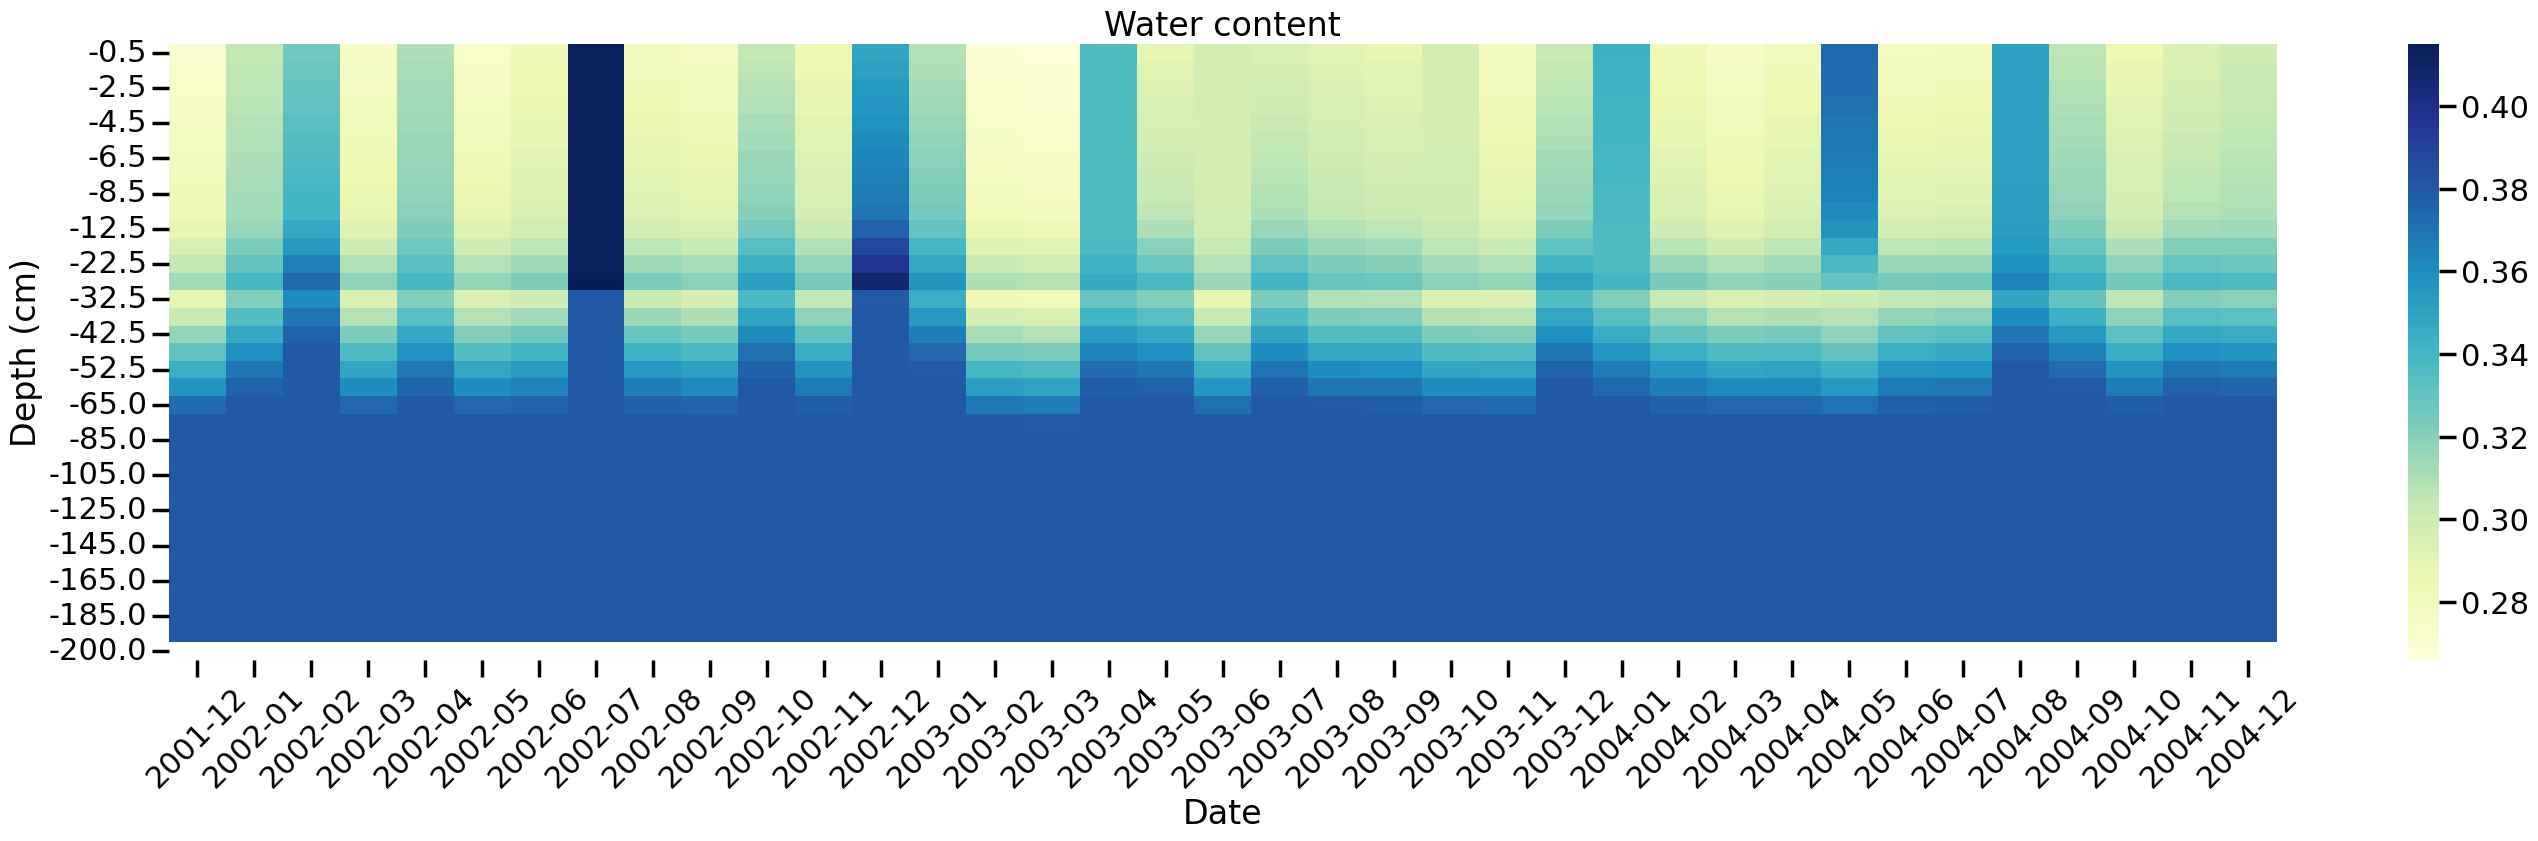

In [20]:
from pyswap.core.plot.watercontent import plot_wcontent

plot_wcontent(result.vap)

/home/zawadzkim/miniconda3/envs/pyswap/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zawadzkim/miniconda3/envs/pyswap/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zawadzkim/miniconda3/envs/pyswap/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zawadzkim/miniconda3/envs/pyswap/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

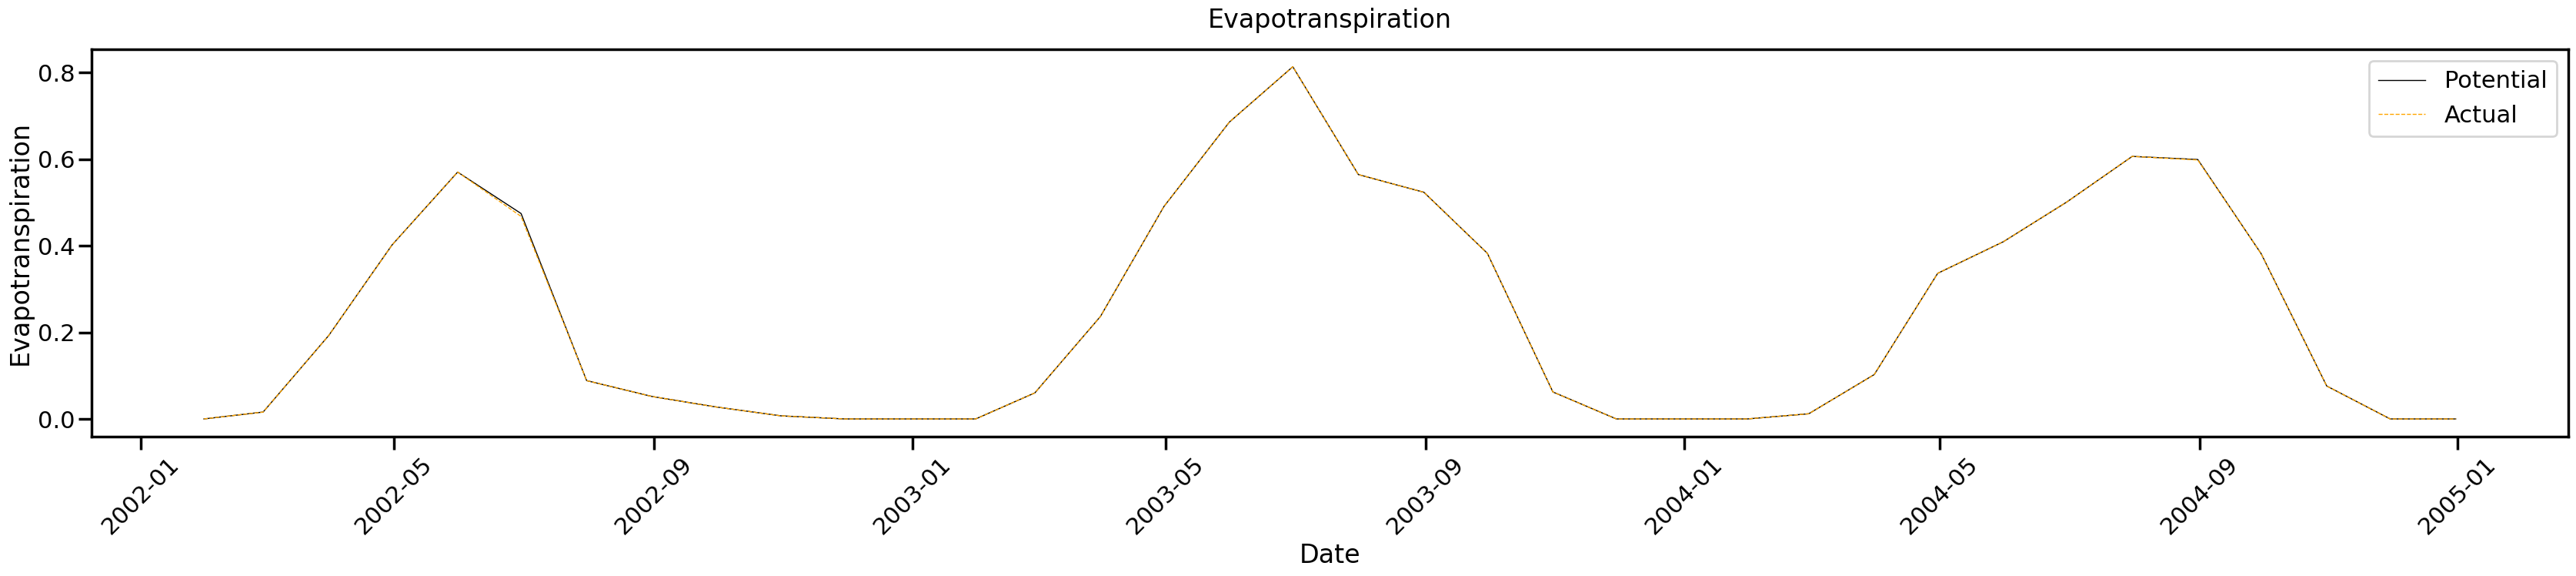

In [21]:
from pyswap.core.plot.evapotranspiration import plot_evapotranspiration

plot_evapotranspiration(result.output.EPOT, result.output.EACT)
